In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor

# Load the data
dft = pd.read_csv('data/train.csv').iloc[:,1:].copy()
df = dft.copy()

# Preprocess the data
df['BsmtFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2']
df['BsmtFinType'] = df['BsmtFinType1'].astype(bool) | df['BsmtFinType2'].astype(bool)
df = df.drop(columns=['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2'])

df['MSSubClass']= df['MSSubClass'].astype(str)

# Adding total sqfootage feature 
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

# Split the data into features and target
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

0:	learn: 77501.6713947	total: 197ms	remaining: 3m 16s
1:	learn: 75164.9312725	total: 200ms	remaining: 1m 39s
2:	learn: 73076.5397163	total: 206ms	remaining: 1m 8s
3:	learn: 71019.6671749	total: 213ms	remaining: 52.9s
4:	learn: 68792.0041597	total: 218ms	remaining: 43.4s
5:	learn: 66676.2201809	total: 222ms	remaining: 36.8s
6:	learn: 64870.2795760	total: 226ms	remaining: 32s
7:	learn: 63024.2067447	total: 229ms	remaining: 28.4s
8:	learn: 61345.1671752	total: 231ms	remaining: 25.5s
9:	learn: 59652.1099546	total: 234ms	remaining: 23.2s
10:	learn: 58120.0246646	total: 236ms	remaining: 21.2s
11:	learn: 56670.9781168	total: 238ms	remaining: 19.6s
12:	learn: 55316.7977717	total: 254ms	remaining: 19.3s
13:	learn: 53934.7704293	total: 259ms	remaining: 18.2s
14:	learn: 52763.3496344	total: 262ms	remaining: 17.2s
15:	learn: 51652.7129106	total: 265ms	remaining: 16.3s
16:	learn: 50525.3956738	total: 268ms	remaining: 15.5s
17:	learn: 49297.7848091	total: 270ms	remaining: 14.7s
18:	learn: 48313.946

C:\Users\Nick\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [17:59:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Model: XGBRegressor
Mean Squared Error: 463104982.2380
------------------------------
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set

C:\Users\Nick\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255675479485.78445, tolerance: 743265025.4249586
  model = cd_fast.sparse_enet_coordinate_descent(


Model: ElasticNet
Mean Squared Error: 816436465.6275
------------------------------
Model: Ridge
Mean Squared Error: 692187629.6078
------------------------------
Model: LinearRegression
Mean Squared Error: 853526842.6700
------------------------------
Model: RandomForestRegressor
Mean Squared Error: 602702333.9948
------------------------------


C:\Users\Nick\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94766549422.10513, tolerance: 743265025.4249586
  model = cd_fast.sparse_enet_coordinate_descent(


Model: Lasso
Mean Squared Error: 809584670.8320
------------------------------
Model: KernelRidge
Mean Squared Error: 691069418.9189
------------------------------


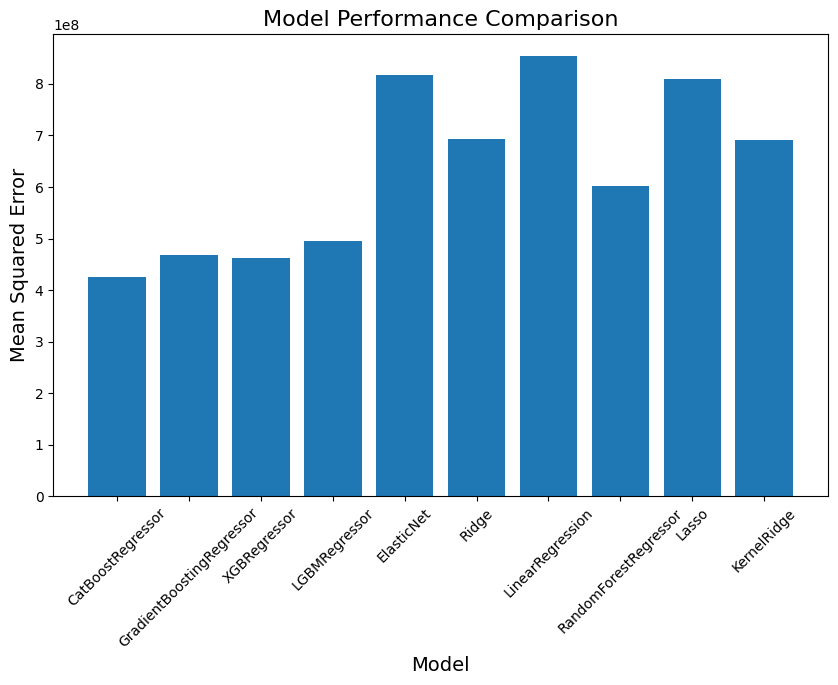

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=49)

from sklearn.impute import SimpleImputer

# Create an imputer object for numerical features
numerical_imputer = SimpleImputer(strategy='mean')

# Create an imputer object for ordinal features
ordinal_imputer = SimpleImputer(strategy='most_frequent')

# Create a pipeline for ordinal features
ordinal_transformer = make_pipeline(ordinal_imputer, OrdinalEncoder())

# Identify ordinal columns - you should replace 'ordinal_cols' with the appropriate columns in your DataFrame
ordinal_cols = ['OverallQual', 'OverallCond']


# Create a pipeline for numerical features
numerical_transformer = make_pipeline(numerical_imputer, StandardScaler(with_mean=False))

categorical_transformer = OneHotEncoder(handle_unknown='ignore')


# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Update your preprocessor to handle ordinal columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('ord', ordinal_transformer, ordinal_cols)
    ],
    remainder='passthrough'
)
models = [CatBoostRegressor(depth = 6,l2_leaf_reg=5, learning_rate= 0.05),
          GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=6, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =3),
        xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1),
        lgb.LGBMRegressor(objective='regression',num_leaves=6,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=18, bagging_seed=12,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11),
        ElasticNet(alpha=0.00055, l1_ratio=.905, random_state=2),
         Ridge(),
         LinearRegression(),
         RandomForestRegressor(),
         Lasso(),
         KernelRidge(),
                             ]


from sklearn.metrics import mean_squared_error

# Define a list to store the mean squared errors
mse_values = []
model_predictions=[]
pipelines= []

for model in models:
    pipeline = make_pipeline(preprocessor, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)
    model_predictions.append(pipeline.predict(X_test))
    pipelines.append(pipeline)
    print(f"Model: {model.__class__.__name__}")
    print(f"Mean Squared Error: {mse:.4f}")
    print("-" * 30)

# Create a bar plot
model_names = [model.__class__.__name__ for model in models]
plt.figure(figsize=(10, 6))
plt.bar(model_names, mse_values)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.xticks(rotation=45)
plt.title('Model Performance Comparison', fontsize=16)
plt.show()

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.tree import DecisionTreeRegressor


class AverageBlender(BaseEstimator, RegressorMixin):
    def __init__(self, estimators, weights=None):
        self.estimators = estimators
        if weights is None:
            weights = [1 / len(estimators)] * len(estimators)
        self.weights = weights
        assert len(estimators) == len(weights)

    def fit(self, X, y):
        for estimator in self.estimators:
            estimator.fit(X, y)
        return self

    def predict(self, X):
        predictions = [estimator.predict(X) * weight for estimator, weight in zip(self.estimators, self.weights)]
        return sum(predictions)

average_blender = AverageBlender(estimators=models, weights=[0.1, 0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1, 0.1, 0.1])
models.append(average_blender)

In [4]:
# Convert the predictions to a DataFrame
model_predictions = pd.DataFrame(model_predictions).T

# Create a decision tree regressor
decision_tree = DecisionTreeRegressor()

# Fit the decision tree on the model predictions
decision_tree.fit(model_predictions, y_test)

#Evaluate the decision tree regressor
y_pred_decision_tree = decision_tree.predict(model_predictions)
decision_tree_mse = mean_squared_error(y_test, y_pred_decision_tree)
print(f"Decision Tree Regressor:")
print(f"Mean Squared Error: {decision_tree_mse:.4f}")
print("-" * 30)

Decision Tree Regressor:
Mean Squared Error: 0.0000
------------------------------


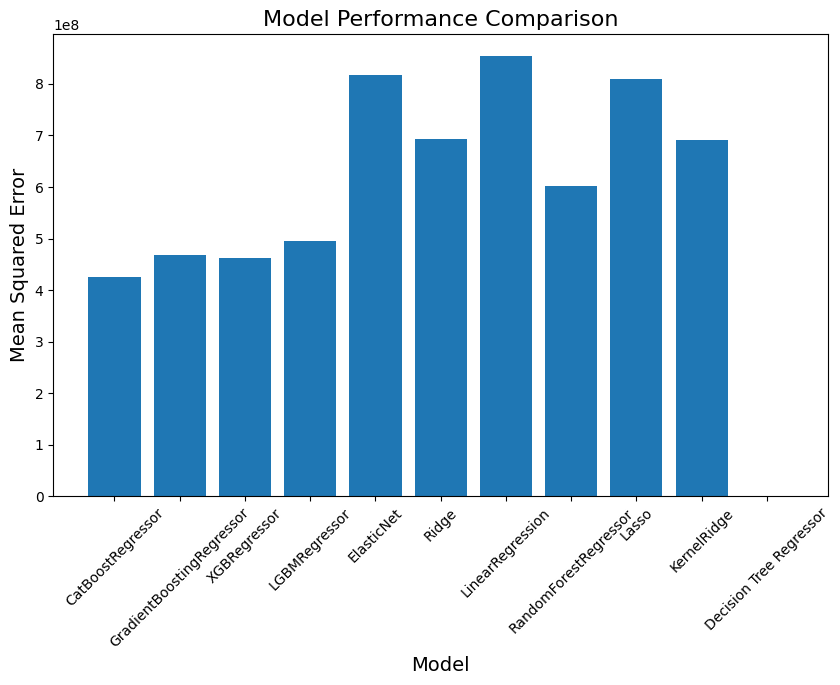

In [5]:
# Add the decision tree regressor to the list of models and MSE values
model_names.append("Decision Tree Regressor")
mse_values.append(decision_tree_mse)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, mse_values)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.xticks(rotation=45)
plt.title('Model Performance Comparison', fontsize=16)
plt.show()

In [6]:
# Load the data
dftest = pd.read_csv('data/test.csv').iloc[:,1:].copy()

# Preprocess the data
dftest['BsmtFinSF'] = dftest['BsmtFinSF1'] + dftest['BsmtFinSF2']
dftest['BsmtFinType'] = dftest['BsmtFinType1'].astype(bool) | dftest['BsmtFinType2'].astype(bool)
dftest = dftest.drop(columns=['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2'])
# Adding total sqfootage feature 
dftest['TotalSF'] = dftest['TotalBsmtSF'] + dftest['1stFlrSF'] + dftest['2ndFlrSF']
dftest['MSSubClass']= dftest['MSSubClass'].astype(str)
# Recreate the ColumnTransformer using the entire dataset
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Create a list to store the predictions of each base model
base_model_predictions = []

# Make predictions using the base models and store the predictions
for i,model in enumerate(models[:-1]):  # exclude the decision tree regressor and average blender
    print(model)

    preds=pipelines[i].predict(dftest)
    base_model_predictions.append(preds)



GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=6,
                          max_features='sqrt', min_samples_leaf=15,
                          min_samples_split=10, n_estimators=3000,
                          random_state=3)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4603, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0468, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1.7817, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2200, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)
LGBMReg

In [7]:
# Convert the base model predictions to a DataFrame
base_model_predictions = pd.DataFrame(base_model_predictions).T

# Make predictions using the decision tree regressor
final_pred = decision_tree.predict(base_model_predictions)

In [8]:
# Load the data
dft= pd.read_csv('data/test.csv')
pd.Series(index=dft['Id'],data=final_pred).rename('SalePrice').to_csv('submission_03232024_3.csv')